In [1]:
from dicesapi import DicesAPI
from dicesapi.jupyter import NotebookPBar
import pandas as pd
from collections import Counter
from matplotlib import pyplot

api = DicesAPI(progress_class=NotebookPBar, logfile='dices.log')

# Download some speeches

In [2]:
speeches = api.getSpeeches(spkr_name='Achilles', progress=True)

# Download the text of the speeches

In [3]:
# create a progress bar
pbar = NotebookPBar(max=len(speeches))

# download text of speeches
for s in speeches:
    if not hasattr(s, 'cts_passage'):
        s.cts_passage = s.getCTS()
    pbar.update()

# Natural language processing with CLTK 

In [4]:
from cltk import NLP

cltk_nlp = {
    'greek': NLP('grc', suppress_banner=True),
    'latin': NLP('lat', suppress_banner=True),
}

cltk_nlp['greek'].pipeline.processes = cltk_nlp['greek'].pipeline.processes[:2]
cltk_nlp['latin'].pipeline.processes = cltk_nlp['latin'].pipeline.processes[:2]

In [5]:
pbar = NotebookPBar(max=len(speeches))

# parse all the speeches
for s in speeches:
    if s.cts_passage is None:
        s.cltk_doc = None
    else:
        s.cltk_doc = cltk_nlp[s.lang](s.cts_passage.text)
    pbar.update()

Let’s take a look at what we get. We’ll use the first speech as an example. First, let me quickly remind myself where this speech comes from and who Achilles is talking to here.

In [6]:
s = speeches[0]

print(s)
print(s.spkr, s.addr)

<Speech 4: Iliad 1.59-1.67>
[<CharacterInstance 5: Achilles>] [<CharacterInstance 2: Agamemnon>]


Okay, this is Achilles’s first speech in the Iliad, where he accosts Agamemnon. Let’s take a look at the full text. We already downloaded the CTS passage above, so all we have to do is use the `.text` property to get the plain text of the passage. This is the text that we passed to CLTK for processing.

In [7]:
print(s.cts_passage.text)

Ἀτρεΐδη νῦν ἄμμε παλιμπλαγχθέντας ὀΐω ἂψ ἀπονοστήσειν, εἴ κεν θάνατόν γε φύγοιμεν, εἰ δὴ ὁμοῦ πόλεμός τε δαμᾷ καὶ λοιμὸς Ἀχαιούς· ἀλλʼ ἄγε δή τινα μάντιν ἐρείομεν ἢ ἱερῆα ἢ καὶ ὀνειροπόλον, καὶ γάρ τʼ ὄναρ ἐκ Διός ἐστιν, ὅς κʼ εἴποι ὅ τι τόσσον ἐχώσατο Φοῖβος Ἀπόλλων, εἴτʼ ἄρʼ ὅ γʼ εὐχωλῆς ἐπιμέμφεται ἠδʼ ἑκατόμβης, αἴ κέν πως ἀρνῶν κνίσης αἰγῶν τε τελείων βούλεται ἀντιάσας ἡμῖν ἀπὸ λοιγὸν ἀμῦναι.


Now, what did CLTK give us? The results of all the processing steps included in a pipeline are returned together as a single, composite object. In this example, we’ve limited the pipeline to the first two steps, normalization and parsing. Here’s what we get when we inspect the CLTK `Doc` object itself:

In [8]:
print(s.cltk_doc)

Doc(language='grc', words=[Word(index_char_start=None, index_char_stop=None, index_token=0, index_sentence=0, string='Ἀτρεΐδη', pos=proper_noun, lemma='Ἀτρεΐδης', stem=None, scansion=None, xpos='Ne', upos='PROPN', dependency_relation='vocative', governor=4, features={Case: [vocative], Gender: [masculine], Number: [singular]}, category={F: [neg], N: [pos], V: [neg]}, stop=None, named_entity=None, syllables=None, phonetic_transcription=None, definition=None), Word(index_char_start=None, index_char_stop=None, index_token=1, index_sentence=0, string='νῦν', pos=adverb, lemma='νῦν', stem=None, scansion=None, xpos='Df', upos='ADV', dependency_relation='advmod', governor=4, features={}, category={F: [neg], N: [pos], V: [pos]}, stop=None, named_entity=None, syllables=None, phonetic_transcription=None, definition=None), Word(index_char_start=None, index_char_stop=None, index_token=2, index_sentence=0, string='ἄμμε', pos=adverb, lemma='ἄμμε', stem=None, scansion=None, xpos='Df', upos='ADV', depen

This is a bit unweildy. You can iterate, index or slice it to get individual words:

In [9]:
s.cltk_doc[0]

Word(index_char_start=None, index_char_stop=None, index_token=0, index_sentence=0, string='Ἀτρεΐδη', pos=proper_noun, lemma='Ἀτρεΐδης', stem=None, scansion=None, xpos='Ne', upos='PROPN', dependency_relation='vocative', governor=4, features={Case: [vocative], Gender: [masculine], Number: [singular]}, category={F: [neg], N: [pos], V: [neg]}, stop=None, named_entity=None, syllables=None, phonetic_transcription=None, definition=None)

Some basic attributes are 
 - `string`, the form of the word that appears in the text
 - `lemma`, the dictionary form
 - `upos`, a "universal" [part of speech tag](https://universaldependencies.org/u/pos/) (useful for Greek/Latin comparisons)
 
Here, we’ll print out all three attributes for each word in Achilles’ speech at Il. 1.59. I’m padding them with spaces to line them up.

In [10]:
for w in s.cltk_doc:
    print(f'{w.string:18}{w.lemma:18}{w.upos}')

Ἀτρεΐδη           Ἀτρεΐδης          PROPN
νῦν               νῦν               ADV
ἄμμε              ἄμμε              ADV
παλιμπλαγχθέντας  παλιμπλάσσω       VERB
ὀΐω               ὀιω               VERB
ἂψ                ἀάς               NOUN
ἀπονοστήσειν,     ἀπονοστέω         VERB
εἴ                εἰ                SCONJ
κεν               ἄν                ADV
θάνατόν           θάνατος           NOUN
γε                γε                ADV
φύγοιμεν,         φεύγω             VERB
εἰ                εἰ                SCONJ
δὴ                δή                ADV
ὁμοῦ              ὁμοῦ              ADV
πόλεμός           πόλεμος           NOUN
τε                τε                CCONJ
δαμᾷ              δαμάω             VERB
καὶ               καί               CCONJ
λοιμὸς            λοιμός            NOUN
Ἀχαιούς·          Ἀχαιός            ADJ
ἀλλʼ              ἀλλʼ              CCONJ
ἄγε               ἄγω               VERB
δή                δή                ADV
τινα              

## Part of speech counts

We can use a Counter and list comprehension to tally all the `upos` elements in a one-liner:

In [11]:
Counter([w.upos for w in s.cltk_doc])

Counter({'PROPN': 4,
         'ADV': 11,
         'VERB': 12,
         'NOUN': 14,
         'SCONJ': 3,
         'CCONJ': 9,
         'ADJ': 6,
         'DET': 2,
         'ADP': 2,
         'PRON': 7})

### Corpus-level POS counts

Let’s wrap this in a second list comprehension, over all the speeches. That gives us one dictionary-like tally per speech. Then we can use a pandas `DataFrame` to convert the list of counters to a tabular format.

⚠️ I just have to allow for the possibility that some speeches weren't retrieved correctly and therefore have `None` instead of a `Doc` object.

In [12]:
pos_tags = pd.DataFrame(
    [Counter([w.upos for w in s.cltk_doc]) for s in speeches if s.cltk_doc is not None])

This lines up the POS tags as columns, and gives us one row per speech. Note that not all the tags are found in all the speeches. Pandas will generate a `NaN` value for missing data.

In [13]:
pos_tags

,PROPN,ADV,VERB,NOUN,SCONJ,CCONJ,ADJ,DET,ADP,PRON,INTJ,AUX,NUM,PUNCT,PART
0,4.0,11.0,12,14,3.0,9.0,6.0,2.0,2.0,7.0,NaN,NaN,NaN,NaN,NaN
1,5.0,5.0,12,9,1.0,3.0,4.0,1.0,2.0,7.0,NaN,NaN,NaN,NaN,NaN
2,3.0,9.0,13,7,1.0,4.0,10.0,2.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
3,3.0,28.0,35,33,5.0,15.0,24.0,3.0,5.0,19.0,2.0,2.0,NaN,NaN,NaN
4,2.0,7.0,3,9,1.0,1.0,1.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,NaN,2.0,4,11,1.0,2.0,1.0,1.0,2.0,3.0,NaN,NaN,NaN,3.0,1.0
99,2.0,10.0,37,37,2.0,11.0,9.0,3.0,4.0,21.0,NaN,2.0,1.0,24.0,1.0
100,NaN,3.0,6,5,NaN,1.0,2.0,NaN,1.0,1.0,NaN,NaN,1.0,4.0,NaN
101,NaN,1.0,7,16,1.0,1.0,4.0,NaN,NaN,6.0,NaN,NaN,NaN,8.0,NaN


I’m going to manually convert those `NaN`s to `0`s. And since all the columns represent counts, I’ll convert everything to type `int`.

In [14]:
pos_tags[pd.isna(pos_tags)] = 0
pos_tags = pos_tags.astype(int)

In [15]:
pos_tags

,PROPN,ADV,VERB,NOUN,SCONJ,CCONJ,ADJ,DET,ADP,PRON,INTJ,AUX,NUM,PUNCT,PART
0,4,11,12,14,3,9,6,2,2,7,0,0,0,0,0
1,5,5,12,9,1,3,4,1,2,7,0,0,0,0,0
2,3,9,13,7,1,4,10,2,0,5,0,0,0,0,0
3,3,28,35,33,5,15,24,3,5,19,2,2,0,0,0
4,2,7,3,9,1,1,1,0,2,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0,2,4,11,1,2,1,1,2,3,0,0,0,3,1
99,2,10,37,37,2,11,9,3,4,21,0,2,1,24,1
100,0,3,6,5,0,1,2,0,1,1,0,0,1,4,0
101,0,1,7,16,1,1,4,0,0,6,0,0,0,8,0


### Normalized counts

Let’s divide each of the counts by the totaly number of tokens in its respective speech, so that speeches of different lengths are more comparable.

First we’ll calculate row sums, which give us the total number of tokens in a given speech (each row is one speech).

In [16]:
totals = pos_tags.sum(axis='columns')
totals

0       70
1       49
2       54
3      174
4       28
      ... 
98      31
99     164
100     24
101     44
102    578
Length: 103, dtype: int64

Now for every column, we divide by the row-based totals. Pandas’ `DataFrame.apply()` will do this really easily. The nomenclature `axis='rows'` means here that the `lambda` function is applied to one column at a time so that the values in `totals` represent different rows.

In [17]:
pos_freq = pos_tags.apply(lambda col: col/totals, axis='rows')

In [18]:
pos_freq

,PROPN,ADV,VERB,NOUN,SCONJ,CCONJ,ADJ,DET,ADP,PRON,INTJ,AUX,NUM,PUNCT,PART
0,0.057143,0.157143,0.171429,0.200000,0.042857,0.128571,0.085714,0.028571,0.028571,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.102041,0.102041,0.244898,0.183673,0.020408,0.061224,0.081633,0.020408,0.040816,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.055556,0.166667,0.240741,0.129630,0.018519,0.074074,0.185185,0.037037,0.000000,0.092593,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.017241,0.160920,0.201149,0.189655,0.028736,0.086207,0.137931,0.017241,0.028736,0.109195,0.011494,0.011494,0.000000,0.000000,0.000000
4,0.071429,0.250000,0.107143,0.321429,0.035714,0.035714,0.035714,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.000000,0.064516,0.129032,0.354839,0.032258,0.064516,0.032258,0.032258,0.064516,0.096774,0.000000,0.000000,0.000000,0.096774,0.032258
99,0.012195,0.060976,0.225610,0.225610,0.012195,0.067073,0.054878,0.018293,0.024390,0.128049,0.000000,0.012195,0.006098,0.146341,0.006098
100,0.000000,0.125000,0.250000,0.208333,0.000000,0.041667,0.083333,0.000000,0.041667,0.041667,0.000000,0.000000,0.041667,0.166667,0.000000
101,0.000000,0.022727,0.159091,0.363636,0.022727,0.022727,0.090909,0.000000,0.000000,0.136364,0.000000,0.000000,0.000000,0.181818,0.000000


## Plotting POS frequencies

We can visualize the corpus of speeches according to the relative proportions of various parts of speech. For example, verbs versus nouns:

<AxesSubplot:title={'center':'Proportional use of nouns and verbs\nin Achilles’ speeches'}, xlabel='VERB', ylabel='NOUN'>

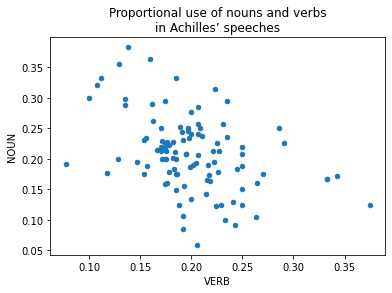

In [28]:
pos_freq.loc[:,['VERB', 'NOUN']].plot.scatter(x='VERB', y='NOUN', title='Proportional use of nouns and verbs\nin Achilles’ speeches')

### Adding category labels

I wonder whether Achilles uses verbs and nouns differently according to the language in which he’s speaking. Or according to the author of the work in which he appears.

To start with, let’s create a table of parameters we might use to organize the data.

In [29]:
labels = pd.DataFrame([
    dict(i=i, 
         lang=s.lang, 
         auth=s.work.author.name,
         work=s.work.title, 
         loc=s.l_range,
         addr=s.addr[0].name,) 
        for i, s in enumerate(speeches) if s.cltk_doc is not None])

In [21]:
labels

,i,lang,auth,work,loc,addr
0,0,greek,Homer,Iliad,1.59-1.67,Agamemnon
1,1,greek,Homer,Iliad,1.85-1.91,Calchas
2,2,greek,Homer,Iliad,1.122-1.129,Agamemnon
3,3,greek,Homer,Iliad,1.149-1.171,Agamemnon
4,4,greek,Homer,Iliad,1.202-1.205,Athena
...,...,...,...,...,...,...
98,106,latin,Statius,Achilleid,1.657-1.660,Deidamia
99,107,latin,Statius,Achilleid,1.892-1.910,Lycomedes
100,108,latin,Statius,Achilleid,2.17-2.19,Thetis
101,109,latin,Statius,Achilleid,2.43-2.48,Odysseus


### Plotting by language

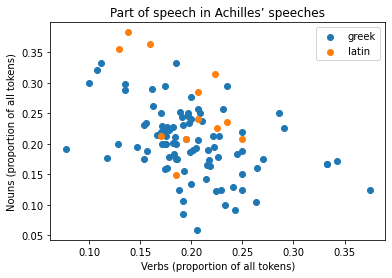

In [36]:
fig, ax = pyplot.subplots()
for g_label, g_data in pos_freq.groupby(labels.lang):
    ax.scatter(g_data.VERB, g_data.NOUN, label=g_label)

ax.xaxis.set_label_text('VERB (proportion of all tokens)')
ax.yaxis.set_label_text('NOUN (proportion of all tokens)')
ax.set_title('Part of speech in Achilles’ speeches')
ax.legend()

### Plotting by author

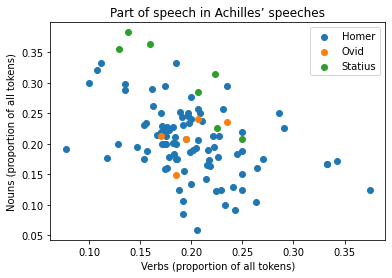

In [37]:
fig, ax = pyplot.subplots()
for g_label, g_data in pos_freq.groupby(labels.auth):
    ax.scatter(g_data.VERB, g_data.NOUN, label=g_label)

ax.xaxis.set_label_text('VERB (proportion of all tokens)')
ax.yaxis.set_label_text('NOUN (proportion of all tokens)')
ax.set_title('Part of speech in Achilles’ speeches')
ax.legend()

### Plotting by work

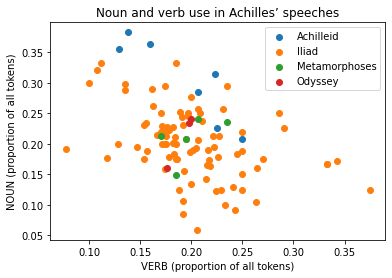

In [44]:
fig, ax = pyplot.subplots()
for g_label, g_data in pos_freq.groupby(labels.work):
    ax.scatter(g_data.VERB, g_data.NOUN, label=g_label)

ax.xaxis.set_label_text('VERB (proportion of all tokens)')
ax.yaxis.set_label_text('NOUN (proportion of all tokens)')
ax.set_title('Noun and verb use in Achilles’ speeches')
ax.legend()

### Inspecting outliers

Let’s take a look at a few of the points. For example, what’s happening on the right-hand side of the plot? Achilles is using proportionally more verbs in these speeches. What might he be talking about, and to whom?

We can use comparisons on the frequencies to subset both the frequency data and the labels. For example, show me only the speeches where verbs make up 30 percent of all tokens or more.

In [25]:
labels.loc[pos_freq.VERB>0.3,:]

,i,lang,auth,work,loc,addr
43,43,greek,Homer,Iliad,20.429-20.429,Hector
59,59,greek,Homer,Iliad,23.19-23.23,Patroclus
73,73,greek,Homer,Iliad,23.707-23.707,Greeks
75,75,greek,Homer,Iliad,23.753-23.753,Greeks


I’m surprised to see four speeches here. It looks to me like there are only three points on the plot. Let’s subset the data using the same criterion to see the actual values being plotted.

In [26]:
pos_freq.loc[pos_freq.VERB>0.3,['NOUN','VERB']]

,NOUN,VERB
43,0.125000,0.375000
59,0.171429,0.342857
73,0.166667,0.333333
75,0.166667,0.333333


The explanation is that two points are precisely on top of one another. Let’s inspect the speeches themselves to see what Achilles is saying here. I’ve included column `i` for this purpose: it gives the speech’s position in the original `speeches` list, so I can trace interesting data back to the speech that produced them.

In [27]:
for i in labels.loc[pos_freq.VERB>0.3,:].i:
    print(i, speeches[i].cts_passage.text)

43 ἆσσον ἴθʼ ὥς κεν θᾶσσον ὀλέθρου πείραθʼ ἵκηαι.
59 χαῖρέ μοι ὦ Πάτροκλε καὶ εἰν Ἀΐδαο δόμοισι· πάντα γὰρ ἤδη τοι τελέω τὰ πάροιθεν ὑπέστην Ἕκτορα δεῦρʼ ἐρύσας δώσειν κυσὶν ὠμὰ δάσασθαι, δώδεκα δὲ προπάροιθε πυρῆς ἀποδειροτομήσειν Τρώων ἀγλαὰ τέκνα σέθεν κταμένοιο χολωθείς.
73 ὄρνυσθʼ οἳ καὶ τούτου ἀέθλου πειρήσεσθον.
75 ὄρνυσθʼ οἳ καὶ τούτου ἀέθλου πειρήσεσθε.


The two identical points come from two speeches that use the same Homeric formula. Although the inflection of the final verb changes, the proportion of nouns and verbs is identical.

## A rough measure of sentence complexity

One more quick plot to show how we might use POS tags, this time as a proxy for syntax. Let’s plot the frequency of coordinating conjunctions ('CCONJ') versus that of subordinating conjunctions ('SCONJ'). Under what circumstances does Achilles favour complex sentences?

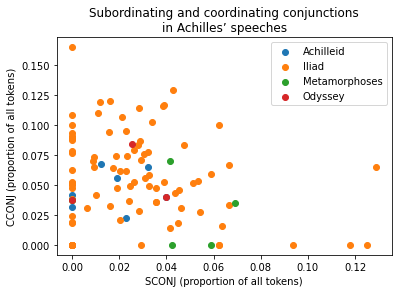

In [41]:
fig, ax = pyplot.subplots()
for g_label, g_data in pos_freq.groupby(labels.work):
    ax.scatter(g_data.SCONJ, g_data.CCONJ, label=g_label)

ax.xaxis.set_label_text('SCONJ (proportion of all tokens)')
ax.yaxis.set_label_text('CCONJ (proportion of all tokens)')
ax.set_title('Subordinating and coordinating conjunctions\nin Achilles’ speeches')
ax.legend()

Because the frequency of both features is relatively low, we see some constraints imposed by the quantized nature of these counts. For example, sentences with exactly one of each will fall along a straight line, at a distance from the origin depending on the length of the sentence.

I was guessing there’d be some interesting difference between the languages, but in fact the biggest difference is between Ovid and Statius: the frequency of subordinating conjunctions alone is enough to separate these two authors.